In [45]:
#import relevant libraries
import numpy as np
import pandas as pd
from keras.datasets import mnist
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Dense,Flatten,Reshape,Lambda
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K 
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow.python.keras.utils import to_categorical
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.python.keras.layers.merge import concatenate as concat
import datetime

In [47]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() #load in the MNIST data

In [48]:
#normalise the data
x_train = x_train.astype('float32') / 255. 
x_test = x_test.astype('float32') / 255.

In [49]:
#split into training and validation sets
x_valid = x_train[50000:]
x_train = x_train[:50000]
y_valid = y_train[50000:]
y_train = y_train[:50000]

In [51]:
#put everythong in the correct shape
n_pixels = np.prod(x_train.shape[1:])
x_train = x_train.reshape((len(x_train), n_pixels))
x_test = x_test.reshape((len(x_test), n_pixels))
x_valid = x_valid.reshape((len(x_valid), n_pixels))

In [52]:
#convert to categorical data
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_valid = to_categorical(y_valid)

In [53]:
# cVAE

In [55]:
#function for producing sampled latent variables to  be used in the end of the encoder
def sampling(args):
    mean, log_var = args
    return K.random_normal(tf.shape(log_var)) * K.exp(log_var/2)+mean

In [56]:
#get the shapes
n_x = x_train.shape[1]
n_y = y_train.shape[1]

10

In [57]:
X = Input(shape=[n_x,])
label = Input(shape=[n_y,])


In [58]:
coding_size = 2 #defien conding size
#make the encoder, input features and labels, output sampled encodings
inputs = concat([X,label])
z= Dense(150, activation = 'selu')(inputs)
z = Dense(100, activation = 'selu')(z)
z = Dense(50, activation = 'selu')(z)
mean = Dense(coding_size)(z)
gamma = Dense(coding_size)(z)
codings = Lambda(sampling)([mean, gamma])
cvae_encoder = Model(inputs = [X,label], outputs = [codings])


In [59]:
#make the decoder, input codings and labels output reconstructions
decoder_input = Input(shape=[coding_size+n_y])
x = Dense(50, activation = 'selu')(decoder_input)
x = Dense(100, activation = 'selu')(x)
x = Dense(150, activation = 'selu')(x)
x = Dense(28 * 28, activation = 'sigmoid')(x)
outputs = Reshape([28,28])(x)
cvae_decoder = Model(inputs=[decoder_input], outputs = [outputs])

In [60]:
#link up encoder and decoder with correct inputs
codings = cvae_encoder([X,label])
ccodings = concat([codings, label])
reconstructions = cvae_decoder(ccodings)
cvae = Model(inputs=[X,label], outputs = [reconstructions])

In [61]:
latent_loss = -0.5 * K.sum(1+gamma - K.exp(gamma)-K.square(mean),axis = 1) #add KL divergence
cvae.add_loss(K.mean(latent_loss)/784)
cvae.compile(loss ='binary_crossentropy', optimizer = 'rmsprop', run_eagerly = True) # choose reconstruction loss

In [62]:
#define checpoints, this case only choosed the lowest validation loss and creates tensorboard log
mcp_save = ModelCheckpoint('.cvae_mnist.hdf5', save_best_only=True, monitor='val_loss', mode='min', save_format="tf", save_weights_only=True)

In [67]:
log_dir = 'logs\\fit\\'+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 27s 546us/sample - loss: 0.1802 - val_loss: 0.1798
Epoch 2/50
50000/50000 [==============================] - 26s 529us/sample - loss: 0.1781 - val_loss: 0.1750
Epoch 3/50
50000/50000 [==============================] - 27s 537us/sample - loss: 0.1765 - val_loss: 0.1740
Epoch 4/50
50000/50000 [==============================] - 26s 514us/sample - loss: 0.1752 - val_loss: 0.1733
Epoch 5/50
50000/50000 [==============================] - 26s 510us/sample - loss: 0.1742 - val_loss: 0.1729
Epoch 6/50
50000/50000 [==============================] - 25s 509us/sample - loss: 0.1734 - val_loss: 0.1715
Epoch 7/50
50000/50000 [==============================] - 26s 515us/sample - loss: 0.1727 - val_loss: 0.1716
Epoch 8/50
50000/50000 [==============================] - 25s 506us/sample - loss: 0.1721 - val_loss: 0.1710
Epoch 9/50
50000/50000 [==============================] - 26s 513us/sample - l

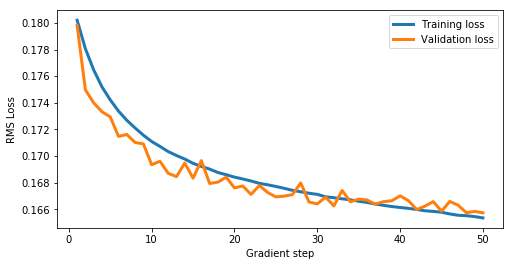

In [69]:
#train the cVAE
history = cvae.fit([x_train,y_train], X_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=([x_valid,y_valid], X_valid),
                callbacks=[mcp_save,tensorboard_callback] )
epochs = range(1, len(history.history["loss"])+1)
plt.figure(1, figsize=(8,4))
plt.plot(epochs, history.history["loss"], lw=3, label="Training loss")
plt.plot(epochs, history.history["val_loss"], lw=3, label="Validation loss")
plt.xlabel("Gradient step"), plt.ylabel("RMS Loss");
plt.legend()
#Keep plot window alive!
plt.show()

In [70]:
cvae.load_weights(filepath=".cvae_mnist.hdf5") #load the best weights

In [71]:
tf.executing_eagerly()

True

W0420 13:05:42.183631 20564 base_layer.py:1814] Layer dense_23 is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



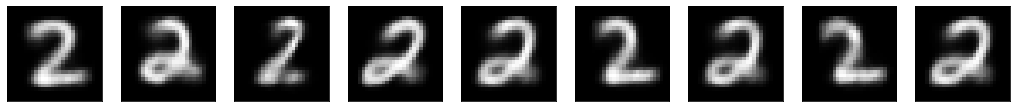

In [72]:
#plot the number of your choice using the lowest validation loss cVAE
n = 10
labels = np.array([[0,0,1,0,0,0,0,0,0,0]*n])
labels=labels.reshape(n,10)
new_codings = tf.random.normal(shape=[n,coding_size])
numbers = cvae_decoder(np.concatenate([new_codings, labels],axis=-1)).numpy()
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(numbers[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [77]:
%tensorboard --logdir logs/fit #output tensorboard logs

Reusing TensorBoard on port 6006 (pid 4692), started 0:02:06 ago. (Use '!kill 4692' to kill it.)